In [11]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.utils import resample

This section plots the frame potential percentage deviation from the Haar values. First, configure the variables.
For the hardware efficient ansatze, change the 'cX' in the load directories to 'cZ' if you want to analyze cZ ansatze.

In [30]:
ansatze = 'ParallelRandom'

if ansatze == 'ParallelRandom':
    frame_potential = np.load('./results/Parallel_Random/bootstrapped_frame_potential.npy')
    samples_array = np.load('./results/Parallel_Random/samples_array.npy')
    qubits = [4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48,50]
    max_l = 14
    min_l = 1
    total_layer_indices = max_l
    # layers to plot for frame potential
    x = np.linspace(min_l, max_l, num=max_l+1-min_l)
    f_lim = [0.001, 100]
    l_lim = 600
elif ansatze == 'LocalRandom':
    frame_potential = np.load('./results/Local_Random/bootstrapped_frame_potential.npy')
    samples_array = np.load('./results/Local_Random/samples_array.npy')
    qubits = [4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48,50]
    max_l = 7
    min_l = 3
    total_layer_indices = max_l*4
    # local random plots layer to qubit ratio, which grows by 0.25 per step
    x = np.linspace(min_l, max_l, num=(max_l-min_l)*4+1)
    f_lim = [0.01, 1000]
    l_lim = 200
elif ansatze == 'HardwareEfficient':
    frame_potential = np.load('./results/Hardware_Efficient_cX/bootstrapped_frame_potential.npy')
    samples_array = np.load('./results/Hardware_Efficient_cX/samples_array.npy')
    qubits = [2,4,6,8,10,14,18,22,26,30,34,38,42,46,50]
    max_l = 10
    min_l=1
    total_layer_indices = max_l
    x = np.linspace(min_l, max_l, num=max_l+1-min_l)
    f_lim = [0.001, 100]
    l_lim = 150

max_n = max(qubits)
min_n = min(qubits)
colors = cm.cool(np.linspace(0, 1, max_n-min_n+1))

First, we show the number of trace values evaluated for each n and l.

/tmp/ipykernel_1947835/3916567976.py:1: RuntimeWarning: divide by zero encountered in log10
  mat = plt.matshow(np.log10(np.clip(samples_array[np.array(qubits)-1], 0, 500000)), cmap=plt.cm.cool, rasterized=True,)


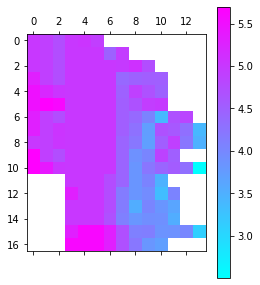

In [31]:
mat = plt.matshow(np.log10(np.clip(samples_array[np.array(qubits)-1], 0, 500000)), cmap=plt.cm.cool, rasterized=True,)
plt.colorbar(mat)
#plt.savefig('Parallel random samples.svg')
plt.show()

Now, we show the frame potentials. You can produce the bootstrap violin plot as in the supplement, or you can plot the figure used in the main manuscript with simple error bars. To choose the type, change `plot_type`. If you wish to reduce clutter, change the qubits in the data configuration in the second cell.

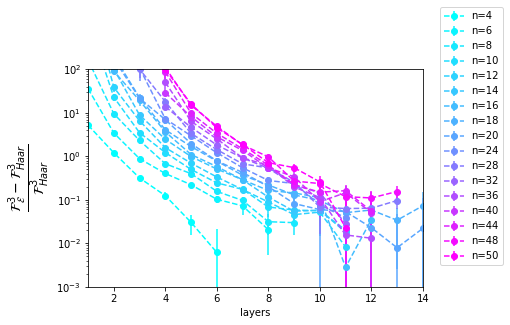

In [32]:
plot_type = 'error bar' # 'violin'

for k in [3]:
    haar = math.factorial(k)

    for n in qubits:
        # select the corresponding portion of the data
        if ansatze == 'LocalRandom':
            # local random plots layer to qubit ratio, which grows by 0.25 per step
            data = np.copy(frame_potential[n-1, min_l*4-1:max_l*4, k-1, :, 0]).T
        else:
            data = np.copy(frame_potential[n-1, min_l-1:max_l, k-1, :, 0]).T
        # rescaling values (mean and standard error)
        data = data/haar
        # calculate the deviation from the haar value
        data -= 1
        means = np.mean(data, axis=0)
        stds = np.std(data, axis=0)
        locations = np.where(means > 0)[0]
        # only plot if there is data available for the trace
        if ~np.all(np.isnan(data)):
            if plot_type == 'error bar':
                plt.errorbar(x[locations], means[locations].reshape(-1), label='n={}'.format(n), yerr=stds[locations].reshape(-1), fmt='o', ls='--', color=colors[n-min_n])
            if plot_type == 'violin':
                plt.plot(x[locations], means[locations].reshape(-1), marker='.', ls='--', color=colors[n-min_n], label='n={}'.format(n))
                parts = plt.violinplot(data, showmeans=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor(colors[n-min_n])
    
    plt.yscale('log')
    plt.ylim(f_lim[0],f_lim[1])
    plt.xlim(min(x),max(x))
    plt.xlabel('layers')
    y_label = '$\\frac{\mathcal{F}_\mathcal{E}^' + str(k) + '-\mathcal{F}_{Haar}^' + str(k) + '}{\mathcal{F}_{Haar}^' + str(k) + '}$'
    plt.ylabel(y_label, fontsize=20)
    plt.legend(loc=(1.05,0.1))
    #plt.savefig('HE bootstrapped.pdf')
    plt.show()

The section below estimates the number of layers needed to become $\epsilon$-approximate $k$ designs. Define the exponential function.

In [33]:
def EXP(x, a, b):
    return a * np.exp(- b * x)

This section fits $\log{\epsilon}$ and calculates $l$. Should take about 20 s.

In [34]:
epsilon = 0.1

ks = [2,3,4,5]
min_k = min(ks)
max_k = max(ks)

# stores all the slopes of the fitted frame potential curves
all_as = []
# stores all the constant of the fitted frame potential curves
all_bs = []
# stores all the layers needed to achieve epsilon approximate k designs
all_ls = []
# stores all the numbers of qubits used
all_ns = []

bootstrap_samples = 300

for i in range(bootstrap_samples):
    # stores all the slopes of the fitted frame potential curves
    sample_as = []
    # stores all the constant of the fitted frame potential curves
    sample_bs = []
    # stores all the layers needed to achieve epsilon approximate k designs
    sample_ls = []
    # stores all the numbers of qubits used
    sample_ns = []
    for k in ks:
        haar = math.factorial(k)
        k_data = np.copy(frame_potential[:, :, k-1, i])
        params = None
        # stores all the numbers of qubits used for this particular k trace
        k_all_ns = []
        # stores all the fitted parameters
        all_params = []

        '''This block fits log(epsilon) as a linear curve'''
        for n in qubits:
            n_data = k_data[n-1]
            n_data[:, 0] -= haar
            try:
                # only fit n that has data
                if ~np.all(np.isnan(n_data)):
                    # this block chooses the last layer that is not nan as the last layer, and the first layer that is not nan as the first layer (at least 3)
                    first_index = np.nan
                    last_index = np.nan
                    for index in range(total_layer_indices):
                        mean = n_data[index, 0]
                        if mean > 5*haar:
                            mean = np.nan
                        if (np.isnan(first_index)) and (not np.isnan(mean)):
                            first_index = index
                        if (np.isnan(mean)) and (not np.isnan(first_index)):
                            last_index = index-1
                            break
                    if np.isnan(last_index):
                        last_index = total_layer_indices-1
                    if np.isnan(first_index):
                        first_index = last_index - 2
                    
                    # selecting appropriate data for fitting
                    xs =  np.arange(last_index+1-first_index) + first_index + 1
                    if ansatze == 'LocalRandom':
                        # converting from index to layer/qubit ratio
                        xs = xs/4
                    ys = n_data[first_index:last_index+1, 0]
                    sigmas = n_data[first_index:last_index+1, 1]
                    # fitting. params is fitted values, and cv is the cross correlation matrix
                    if ys.shape[0] > 2:
                        try:
                            results, cv = op.curve_fit(EXP, xs, ys, sigma=sigmas)
                            a = results[0]
                            b = results[1]
                            # Calculating thelayers needed for intersecpt
                            l = (np.log(a)-2*np.log(epsilon)+2*n*k*np.log(2))/b
                            # creating correlated fitted variables
                            all_params.append(np.array([a,b,l]))
                            # indicate that this n value has results
                        except:
                            #print('fit failed.')
                            all_params.append([np.nan, np.nan, np.nan])
                    else:
                        #print('Valid data range too short.')
                        all_params.append([np.nan, np.nan, np.nan])
                    k_all_ns.append(n)
                    
            except:
                print(n,k)
                print(n_data)
                print(last_index, first_index)
                print(xs, ys)
                raise

        '''This block calculates the layers needed to become epsilon approximate k designs by calculating the intersect of  the fitted curves'''
        all_params = np.array(all_params)
        k_all_ns = np.array(k_all_ns)
        # update what n values have results for this k
        sample_ns.append(k_all_ns)
        # correlated epsilon slopes
        a = all_params[:,0]
        # correlated epsilon bias
        b = all_params[:,1]
        # calculating layers needed 
        l = all_params[:,2]
        # updating results to storage lists
        sample_as.append(a)
        sample_bs.append(b)
        sample_ls.append(l)
    
    all_as.append(sample_as)
    all_bs.append(sample_bs)
    all_ls.append(sample_ls)
    all_ns.append(sample_ns)

all_ls = np.array(all_ls)

/tmp/ipykernel_1947835/2540445574.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(- b * x)
/tmp/ipykernel_1947835/2540445574.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(- b * x)
/home/minzhao.liu/.conda/envs/qtensor_ai/lib/python3.9/site-packages/scipy/optimize/minpack.py:487: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/home/minzhao.liu/.conda/envs/qtensor_ai/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1947835/913556098.py:74: RuntimeWarning: invalid value encountered in log
  l = (np.log(a)-2*np.log(epsilon)+2*n*k*np.log(2))/b


The following analysis is done for small qubit values to establish slopes and $k$ dependence.

In [35]:
def Linear(x, a, b):
    return a * x + b

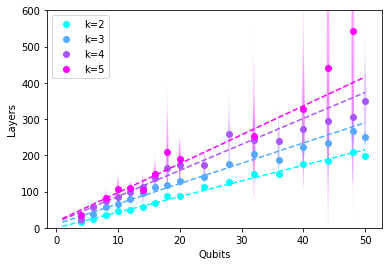

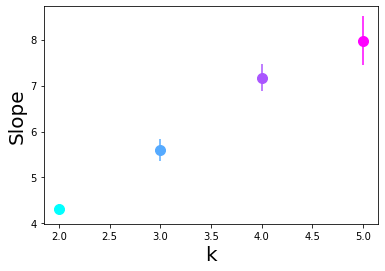

In [36]:
analytic_ns = np.linspace(1, max_n, 100)
slopes = []
slope_err = []
# plotting scaling and fitted curves for few qubits
for k in [2,3,4,5]:
    i = k-min_k
    means = np.percentile(all_ls[:, i], [50], axis=0).reshape(-1)
    plt.plot(all_ns[0][i], means, marker='o', ls='', color=cm.cool(i/3), label='k={}'.format(k))
    parts = plt.violinplot(all_ls[:, i], all_ns[0][i], showmeans=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(cm.cool(i/3))
    # Select only locations that givees valid mean values. Skips first data point to avoid finite size effects (we are ignoring the log(n) and log(1/epsilon) terms).
    locations = np.where(np.nanmean(all_ls[:, i], axis=0)>0)[0][1:]
    params, cv = op.curve_fit(Linear, all_ns[0][i][locations], np.nanmean(all_ls[:, i, locations], axis=0), sigma=np.nanstd(all_ls[:, i, locations], axis=0))
    slopes.append(params[0])
    slope_err.append(cv[0,0])
    plt.plot(analytic_ns, Linear(analytic_ns, params[0], params[1]), '--', color=cm.cool(i/3))

#plt.xlim(4,20)
plt.ylim(0, l_lim)
plt.xlabel('Qubits')
plt.ylabel('Layers')
plt.legend()
#plt.savefig('Parallel random fit bootstrapped.pdf')
plt.show()

# plot the fitted slopes
for i, k in enumerate([2,3,4,5]):
    plt.errorbar(k, slopes[i], yerr=np.sqrt(slope_err[i]), fmt='o', markersize=10, color=cm.cool(i/3))
#plt.yticks([1,2,3,4], fontsize=20)
plt.ylabel('Slope', fontsize=20)
#plt.xticks([2,3,4], fontsize=20)
plt.xlabel('k', fontsize=20)
#plt.ylim(1, 4)
#plt.savefig('parallel random slopes bootstrapped.pdf')
plt.show()

The following is the convergence analysis used in the supplement.

In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sklearn.utils import resample

/home/minzhao.liu/.conda/envs/qtensor_ai/lib/python3.9/site-packages/tqdm-4.64.0-py3.9.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data for the circuit convergence in supplement Fig. 5.

In [2]:
f = torch.load('/home/minzhao.liu/Frame_Potential/results/Parallel_Random/n_50_l_11.pt')
f = torch.abs(f)**6
bootstrap_samples = 300
means = np.zeros([bootstrap_samples, 12])
samples = np.zeros(12)
for i in range(1,13):
    sample = f[:2**i].numpy()
    samples[i-1] = 2**i
    for j in range(bootstrap_samples):
        subset = resample(sample, n_samples=2**i)
        mean = subset.mean()
        means[j, i-1] = mean
means = means/6 - 1

(1.0, 9182.0)

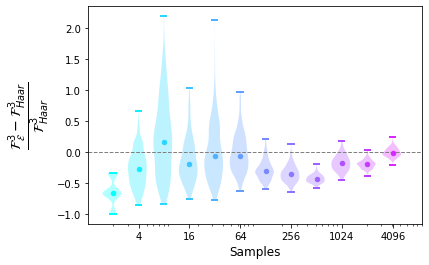

In [4]:
fig1, ax1 = plt.subplots()
for i in range(12):
    parts = ax1.violinplot(means[:,i].reshape(-1, 1), np.array([samples[i]]), widths=samples[i]/2, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(cm.cool(i/13))
    medians = np.percentile(means[:,i], [50], axis=0)
    ax1.scatter(samples[i], medians, marker='o', color=cm.cool(i/13), s=20, zorder=3)
    ax1.hlines(means[:,i].min(), samples[i]*0.9, samples[i]*1.1, color=cm.cool(i/13), linestyle='-', lw=2)
    ax1.hlines(means[:,i].max(), samples[i]*0.9, samples[i]*1.1, color=cm.cool(i/13), linestyle='-', lw=2)

ax1.plot(np.array([1,2,4,8,16,32,64,128,246,512,1024,2048,4096,9182]), np.zeros(14), '--', linewidth=1, color='gray')
ax1.set_xscale('log')
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('$\\frac{\mathcal{F}_\mathcal{E}^3-\mathcal{F}_{Haar}^3}{\mathcal{F}_{Haar}^3}$', fontsize=20)
ax1.set_xticks([4,16,64,256,1024,4096])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlim(1,9182)
#plt.savefig('convergence.pdf')

